# CNN
Laden des auf IDS17 trainierten Modells  
Test auf IDS18 mit reduzierten Benign Daten

In [ ]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix

2024-10-30 10:23:50.127706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 10:23:50.135142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 10:23:50.143369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 10:23:50.145778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 10:23:50.152705: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='32_cnn_test.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS18

In [8]:
# IDS18 Datensatz einlesen
df = pd.read_parquet(os.path.join(parquet_verzeichnis_ids18 + '_prep_0'))
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

2024-10-30 10:32:57 - INFO - Class distribution
Label
BENIGN                                          5935340
DoS Hulk                                        1803160
DDoS-LOIC-HTTP                                   289328
Botnet Ares                                      142921
SSH-BruteForce                                    94197
Infiltration - NMAP Portscan                      89374
DoS GoldenEye                                     22560
DoS Slowloris                                      8490
Web Attack - Brute Force                            131
Web Attack - XSS                                    113
Web Attack - SQL                                     39
Infiltration - Communication Victim Attacker          0
Infiltration - Dropbox Download                       0
Infiltration - Dropbox Download - Attempted           0
FTP-BruteForce - Attempted                            0
Botnet Ares - Attempted                               0
DDoS-HOIC                                         

In [4]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       

In [5]:
df.shape

(8385653, 84)

### Trennen von Features und Labels

In [9]:
# Letzte Spalte 'Label' ist die Zielvariable

X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (8385653, 83)
Form von y: (8385653,)


In [10]:
X.head(2)

,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd RST Flags,Bwd RST Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time
0,3389,6,1876839,8,7,1144.0,1581.0,677.0,0.0,143.0,227.969925,1173.0,0.0,225.857147,430.098602,1451.909302,7.992161,134059.921875,245567.21875,953133.0,4.0,1876839.0,268119.84375,395317.375,1156259.0,4.0,1729590.0,288265.0,326312.25,953133.0,139432.0,5,5,0,0,1,0,172,152,4.262486,3.729675,0.0,1173.0,181.666672,327.253876,107095.095238,0,2,1,10,14,0,1.0,1.0,0.875,181.666667,143.0,225.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,105.0,8192.0,62856.0,5.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1876839.0
1,53,17,250,1,1,43.0,59.0,43.0,43.0,43.0,0.000000,59.0,59.0,59.000000,0.000000,408000.000000,8000.000000,250.000000,0.00000,250.0,250.0,0.0,0.00000,0.000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0,0,0,0,0,0,8,8,4000.000000,4000.000000,43.0,59.0,51.000000,11.313708,128.000000,0,0,0,0,0,0,0.0,0.0,1.000,51.000000,43.0,59.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,29.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0


In [11]:
y.head(2)

0    BENIGN
1    BENIGN
Name: Label, dtype: category
Categories (25, object): ['BENIGN', 'DoS Hulk', 'FTP-BruteForce - Attempted', 'SSH-BruteForce', ..., 'DoS GoldenEye', 'DoS GoldenEye - Attempted', 'DoS Slowloris', 'DoS Slowloris - Attempted']

### Label Encoding für y

In [ ]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

In [13]:
print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [ ]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)
print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

### Umformen der Daten für das CNN

In [16]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (8385653, 83, 1)


In [ ]:
X_test, y_test = X_reshaped, y_encoded
X_test.shape, y_test.shape

### Überprüfen der Klassenverteilung

In [19]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 5935340 Beispiele (70.78%)
  Klasse 1: 142921 Beispiele (1.70%)
  Klasse 2: 289328 Beispiele (3.45%)
  Klasse 3: 22560 Beispiele (0.27%)
  Klasse 4: 1803160 Beispiele (21.50%)
  Klasse 5: 8490 Beispiele (0.10%)
  Klasse 6: 89374 Beispiele (1.07%)
  Klasse 7: 94197 Beispiele (1.12%)
  Klasse 8: 131 Beispiele (0.00%)
  Klasse 9: 39 Beispiele (0.00%)
  Klasse 10: 113 Beispiele (0.00%)



### Laden des Modells

In [20]:
# from tensorflow import keras
# import joblib

# Laden des Modells
cnn_model = keras.models.load_model('ids17_cnn_model.h5')

# Laden des Label Encoders und Scalers
# label_encoder = joblib.load('label_encoder.pkl')
# scaler = joblib.load('scaler.pkl')

I0000 00:00:1730280951.952619  776658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730280952.060268  776658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730280952.060610  776658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730280952.076061  776658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730280952.076310  776658 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Evaluierung des Modells auf dem Testdatensatz

In [21]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

I0000 00:00:1730280963.133281  779002 service.cc:146] XLA service 0x7f5148004a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730280963.133484  779002 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-30 10:36:03.164047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 10:36:03.213528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   186/262052 ━━━━━━━━━━━━━━━━━━━━ 3:33 816us/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9896      

I0000 00:00:1730280963.720695  779002 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262052/262052 ━━━━━━━━━━━━━━━━━━━━ 269s 1ms/step - loss: 4.2425 - sparse_categorical_accuracy: 0.7650
Testverlust: 4.2553
Testgenauigkeit: 0.7642


### Klassifikationsbericht und eine Konfusionsmatrix

In [22]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

262052/262052 ━━━━━━━━━━━━━━━━━━━━ 180s 687us/step


/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.75      0.99      0.86   5935340
                 Botnet Ares       1.00      1.00      1.00    142921
              DDoS-LOIC-HTTP       1.00      0.97      0.98    289328
               DoS GoldenEye       0.96      0.84      0.90     22560
                    DoS Hulk       0.00      0.00      0.00   1803160
               DoS Slowloris       0.96      0.41      0.57      8490
Infiltration - NMAP Portscan       0.70      0.85      0.77     89374
              SSH-BruteForce       0.00      0.00      0.00     94197
    Web Attack - Brute Force       0.00      0.00      0.00       131
            Web Attack - SQL       0.00      0.00      0.00        39
            Web Attack - XSS       0.45      0.94      0.61       113

                    accuracy                           0.76   8385653
                   macro avg       0.53      0.54      0.52   8385653
                we

Visualisierung der Konfusionsmatrix

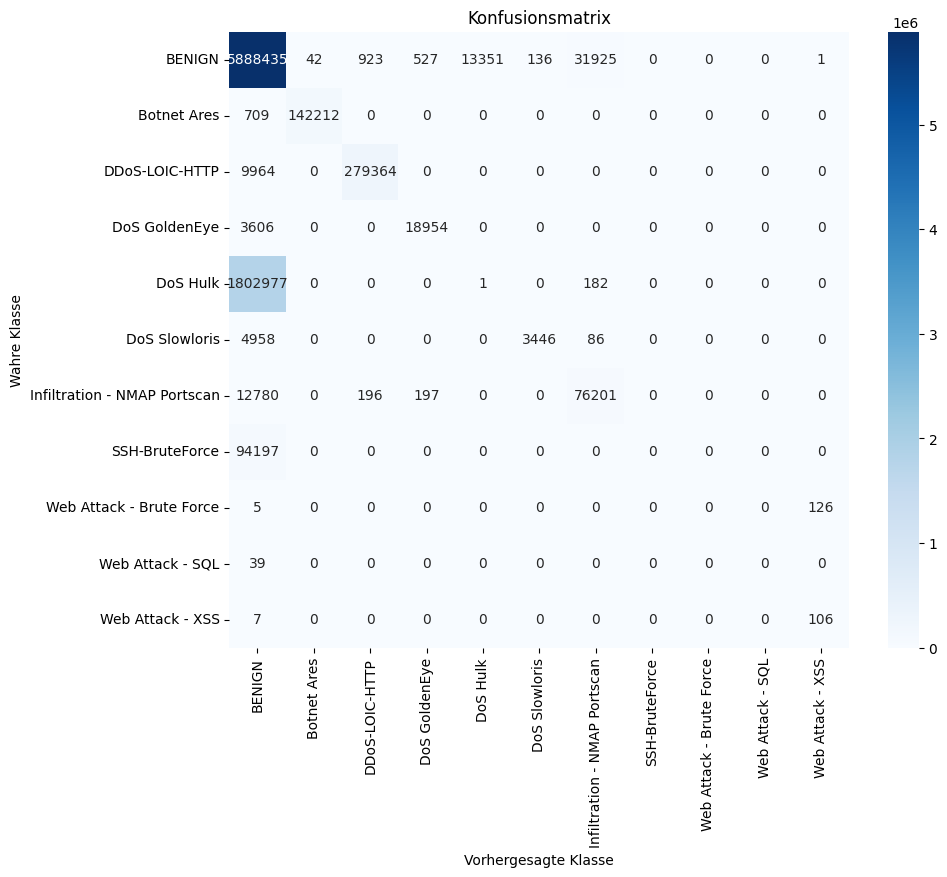

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Wichtige Überlegungen
- Hyperparameter-Tuning: Experimentieren Sie mit der Anzahl der Epochen, der Batch-Größe, der Lernrate und anderen Hyperparametern, um die Modellleistung zu verbessern.
- Klassengewichtung: Wenn Ihr Datensatz unausgewogen ist, können Sie Klassengewichte verwenden, um das Modell zu sensibilisieren.
- Cross-Validation: Für eine robustere Bewertung könnten Sie Kreuzvalidierungstechniken anwenden.
- Feature-Engineering: Überlegen Sie, ob zusätzliche Feature-Auswahl oder -Extraktion die Leistung verbessern könnte.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Beim Training des Modells
cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)
